# Second model
- Implement some new pipeline functionality. 
- Refactor pre-processing and pipeline code into '../lib'

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib.preprocessing import preprocess
from lib.pipeline import f1_scorer, FeatureExtractor

In [5]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [6]:
X_train = preprocess(train).drop('Target', axis = 1)
X_test = preprocess(test)
y_train = train['Target']

In [7]:
test_features = ['meaneduc'] + [
    'wall_quality', 'roof_quality', 'floor_quality'] + [
    'pisonotiene', 'cielorazo'] + [
    'asset_index'] + [
    'hogar_nin', 'overcrowding']

X_train[test_features].head()

,meaneduc,wall_quality,roof_quality,floor_quality,pisonotiene,cielorazo,asset_index,hogar_nin,overcrowding
0,10.0,1,0,0,0,1,1,0,1.000000
1,12.0,1,1,1,0,1,2,0,1.000000
2,11.0,1,2,2,0,1,1,0,0.500000
3,11.0,2,2,2,0,1,2,2,1.333333
4,11.0,2,2,2,0,1,2,2,1.333333


In [8]:
model = Pipeline(steps=[('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                ('random_forest', RandomForestClassifier(random_state = 1))])

kfold = StratifiedKFold(n_splits=5, random_state=1)

In [9]:
DEPTHS = list(range(10,16))
param_grid = dict(random_forest__max_depth=DEPTHS)
grid = GridSearchCV(model, param_grid=param_grid, cv=kfold, scoring=f1_scorer)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])

best_params = grid.best_params_

In [10]:
DEPTH = best_params['random_forest__max_depth']

model = Pipeline(steps=[('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                ('random_forest', RandomForestClassifier(random_state=1, max_depth=DEPTH))])

model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('feature_extraction', FeatureExtractor(cols=['meaneduc', 'wall_quality', 'roof_quality', 'floor_quality', 'pisonotiene', 'cielorazo', 'asset_index', 'hogar_nin', 'overcrowding'])), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('random_forest', Ra...estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))])

In [11]:
cv_score = cross_val_score(model, X_train, y_train, cv = kfold, scoring = f1_scorer)
print(cv_score.mean())
print(f'10 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

0.36153155961639366
10 Fold Cross Validation F1 Score = 0.3615 with std = 0.0205


In [12]:
estimator = model.steps[-1][1]
feature_importances = pd.DataFrame({'feature': test_features, 'importance': estimator.feature_importances_})
feature_importances.sort_values('importance', ascending=False)

,feature,importance
0,meaneduc,0.342802
8,overcrowding,0.195968
7,hogar_nin,0.143856
6,asset_index,0.078292
3,floor_quality,0.064188
1,wall_quality,0.059676
2,roof_quality,0.058224
5,cielorazo,0.049399
4,pisonotiene,0.007594


# Submission

In [13]:
y_pred = model.predict(X_test)

(array([ 1312.,     0.,     0.,  3652.,     0.,     0.,  1817.,     0.,
            0., 17075.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

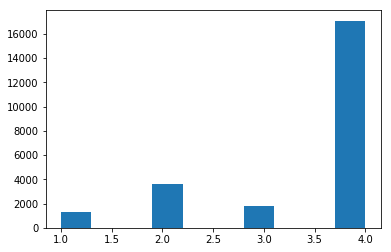

In [14]:
plt.hist(y_pred)

In [15]:
y_pred_series = pd.Series(y_pred, name = 'Target')
submission = pd.concat([X_test['Id'], y_pred_series], axis=1)

In [16]:
submission.to_csv('../submission.csv', index=None)

In [17]:
submission.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4
